In [1]:
from alpdesign.utils import *
from alpdesign.mlp import *
from jax_unirep import get_reps
import alpdesign
import numpy as np
import matplotlib.pyplot as plt
import jax_unirep
import haiku as hk
import jax
import jax.numpy as jnp
import functools
from sklearn.decomposition import PCA

In [2]:
def hamming(seq1, seq2): # seq1 and seq2 are of same length
    seqlist1 = list(seq1)
    seqlist2 = list(seq2)
    hamming_distance = 0.
    for i in range(len(seqlist1)):
        if seqlist1[i] == seqlist2[i]:
            continue
        hamming_distance += 1.
    return 1 - hamming_distance / len(seqlist1)

In [3]:
target_seq = 'GIGAVLKVLTTGLPALISWIKRKRQQ'
oh_vec = encode_seq(list(target_seq))
oh_unirep = seq2useq(oh_vec)
target_rep = differentiable_jax_unirep(oh_unirep)
#print(target_rep.shape)
seqs = ['GIGAVLKVLKAGLPALIVTLKRKIVQ',
       'PPGATLKKHTTGSVALISWIWARIQQ',
       'GIGAVLKVLTTGLKTLISAAKRKRAA',
       'HAPPVLKVLTTGLAPPLVWIKRKRTH',
       'GIGAVLUIHKLSSVAAWRPPKRKRQQ',
       'PTWIIFLKAQWEQHSNLTNMRTFPEV',
        'TISHFVCNHDICAWIKDMQAMQIKMC',
        'CESWLWKRLFDGHADRWRSMPDYPIW',
        'YLVENPLMFPLVAAFIHQWTRQISWH',
        'QTEERLEAQISIYYIGAWSHYKVTDE']
reps = get_reps(seqs)[0]
labels = []
for seq in seqs:
    labels.append(hamming(target_seq, seq))
labels = np.array(labels)

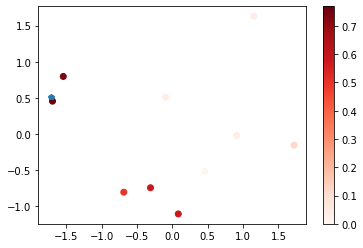

In [4]:
pca = PCA(n_components=2)
pca.fit(reps)
proj_x = pca.transform(reps)
plt.scatter(proj_x[:,0], proj_x[:,1], c=labels, cmap=plt.get_cmap('Reds'))
plt.colorbar()
proj_l = pca.transform(target_rep)
plt.plot(proj_l[:,0], proj_l[:,1], 'p')

In [5]:
key = jax.random.PRNGKey(0)
c = alpdesign.EnsembleBlockConfig()
forward_fxn, full_forward_fxn = alpdesign.build_model(c)
full_forward_t = hk.without_apply_rng(hk.transform(full_forward_fxn))

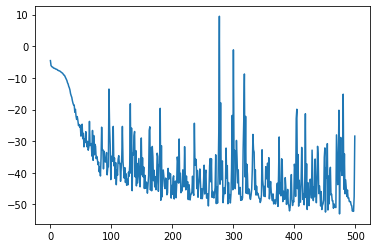

In [6]:
params, losses = alpdesign.ensemble_train(
    key, full_forward_t, c, reps, labels, epochs=500, learning_rate=1e-3)
forward_t = hk.without_apply_rng(hk.transform(forward_fxn))
forward = functools.partial(forward_t.apply, params)
plt.plot(losses)

In [7]:
# e2e is a haiku func
def e2e(logits):
    s = alpdesign.SeqpropBlock()(logits)
    us = alpdesign.seq2useq(s)
    u = alpdesign.differentiable_jax_unirep(us)
    return forward(u)
e2e_t = hk.transform(e2e)
init_logits = jax.random.normal(key, shape=((26, 20)))
e2e_params = e2e_t.init(key, init_logits)

def e2e_fxn(x, key):
    e2e_params, logits = x
    yhat = e2e_t.apply(e2e_params, key, logits)
    return yhat

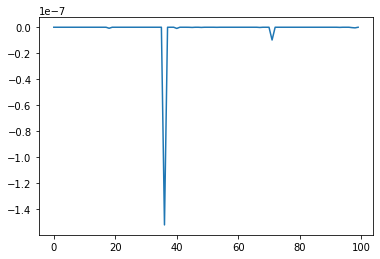

In [8]:
batch_size = 8
for i in range(10):
    key, tkey = jax.random.split(key, num=2)
    init_x = jax.random.normal(key, shape=(26, 20))
    x, loss_curve = alpdesign.bayes_opt(key, e2e_fxn, labels, (e2e_t.init(key, init_logits), init_x), iter_num=100)
    plt.plot(loss_curve)
    break
    params, losses = alpdesign.ensemble_train(
        tkey, full_forward_t, c, reps, labels, epochs=500, learning_rate=1e-3)    
    forward_t = hk.without_apply_rng(hk.transform(forward_fxn))
    forward = functools.partial(forward_t.apply, params)
    rb = x[0]
    logits = x[1]
    vec = alpdesign.seq.forward_seqprop.apply(rb, key, logits)
    s = decode_seq(vec)
    reps = np.concatenate((reps, get_reps([s])[0]))
    y = hamming(target_seq, s)
    print(reps.shape)
    print(s, y)
    labels = np.concatenate((labels, np.array(y).reshape(1,)))
    
    plt.figure()
    proj_x = pca.transform(reps)
    print(proj_x)
    plt.scatter(proj_x[:,0], proj_x[:,1], c=labels, cmap=plt.get_cmap('Reds'))
    plt.colorbar()
    proj_l = pca.transform(target_rep)
    plt.plot(proj_l[:,0], proj_l[:,1], 'p')
    plt.plot(proj_x[-1, 0], proj_x[-1, 1], 'o', color='green')    
    plt.show()
    